In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import category_encoders as ce
from ast import literal_eval
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor

In [264]:
# We read the dataset.
df = pd.read_csv('popularity_score_dataset.csv')

# Exploratory Data Analysis

We get a glimpse of the first 5 rows of the dataset to understand the nature of the variables.

In [159]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In this way, we look at the number of observations in the dataset and the number of columns.

In [160]:
df.shape

(114000, 21)

Then, we check the type of the variables.

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

We notice that there is an index variable "Unnamed: 0" and we remove it.

In [265]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

Now we are left with the following variables.

In [163]:
df.columns

Index(['track_id', 'artists', 'album_name', 'track_name', 'popularity',
       'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')

We check whether there are null values and where.

In [164]:
null_counts = df.isna().sum()

if null_counts.sum() == 0:
    print('There are no null values')
else:
    print(null_counts)

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


Because there are only 3 null values, we remove their rows as they are a very low number compared to the entire dataset.

In [266]:
df.dropna(inplace=True)

In [166]:
null_counts = df.isna().sum()

if null_counts.sum() == 0:
    print('There are no null values')
else:
    print(null_counts)

There are no null values


At this point, we look at the unique values in the dataset and we notice that some might be duplicated.

In [167]:
df.nunique(axis = 0)

track_id            89740
artists             31437
album_name          46589
track_name          73608
popularity            101
duration_ms         50696
explicit                2
danceability         1174
energy               2083
key                    12
loudness            19480
mode                    2
speechiness          1489
acousticness         5061
instrumentalness     5346
liveness             1722
valence              1790
tempo               45652
time_signature          5
track_genre           114
dtype: int64

Indeed, there are 89741 track_ids out of 114000 entries. Therefore we check for duplicated values and then we remove them.

In [168]:
dupl_counts = df.duplicated().sum()

if dupl_counts.sum() == 0:
    print('There are no duplicated values')
else:
    print(dupl_counts)

450


In [267]:
df.drop_duplicates(inplace=True)

In [170]:
dupl_counts = df.duplicated().sum()

if dupl_counts.sum() == 0:
    print('There are no duplicated values')
else:
    print(dupl_counts)

There are no duplicated values


We check again and notice that the variable track_id still looks like it has duplicates. This is an issue we will deal with during the data pre processing.

# Descriptive Statistics

We calculate descriptive statistics and format each statistic as a float with a fixed number of decimal places.

In [171]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,113549.000000,113549.000000,113549.000000,113549.000000,113549.000000,113549.000000,113549.000000,113549.000000,113549.000000,113549.000000,113549.000000,113549.000000,113549.000000,113549.000000
mean,33.324433,228081.370844,0.567031,0.642091,5.309452,-8.243408,0.637866,0.084674,0.314064,0.155703,0.213613,0.474205,122.175745,3.904218
std,22.283855,106413.098525,0.173409,0.251053,3.560147,5.011422,0.480620,0.105762,0.331906,0.309217,0.190462,0.259204,29.972954,0.432117
min,0.000000,8586.000000,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,174184.000000,0.456000,0.473000,2.000000,-9.998000,0.000000,0.035900,0.016800,0.000000,0.098000,0.260000,99.296000,4.000000
50%,35.000000,213000.000000,0.580000,0.685000,5.000000,-6.997000,1.000000,0.048900,0.168000,0.000041,0.132000,0.464000,122.020000,4.000000
75%,50.000000,261588.000000,0.695000,0.854000,8.000000,-5.001000,1.000000,0.084500,0.596000,0.048700,0.273000,0.683000,140.074000,4.000000
max,100.000000,5237295.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


We can notice that song's features variables such has tempo or loudness have a different range of values which are much higher than the others, whose values are mostly between 0 and 1.

We plot a heatmap to display the correlation among variables.

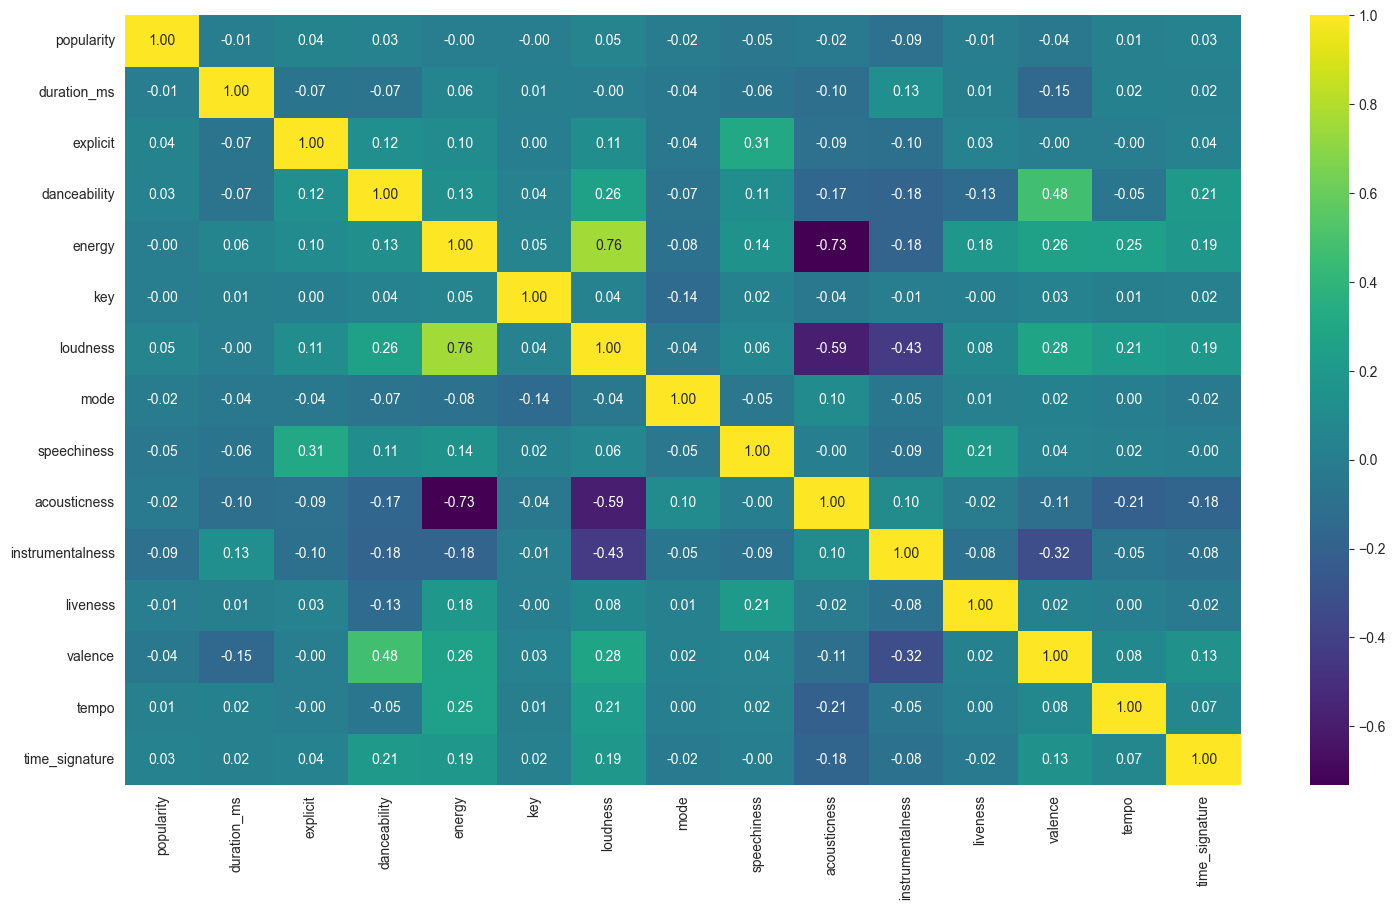

In [172]:
corr = df.corr()

plt.figure(figsize=(18, 10))
sns.heatmap(corr, cmap="viridis", annot=True, fmt=".2f")
plt.show()

Most of the variables are not correleted, with the exception of:
- "acousticness" and "energy", which are highly negatively correlated. This is probably because tracks that have a lot of acoustic sounds tend to be more mellow and subdued, which would result in low energy values. Conversely, tracks that have more electronic sounds might be more energetic and upbeat, resulting in high energy values.
- "loudness" and "energy", which are highly positively correlated. Loudness is a measure of the sound pressure level of a track, while energy is a perceptual measure of the intensity and activity of a track. Therefore, the high correlation is reasonable, as both measures are related to the subjective impression of the track being "loud" or "powerful"

We create a histogram for each variable in the dataset, which shows the distribution of values for that variable.

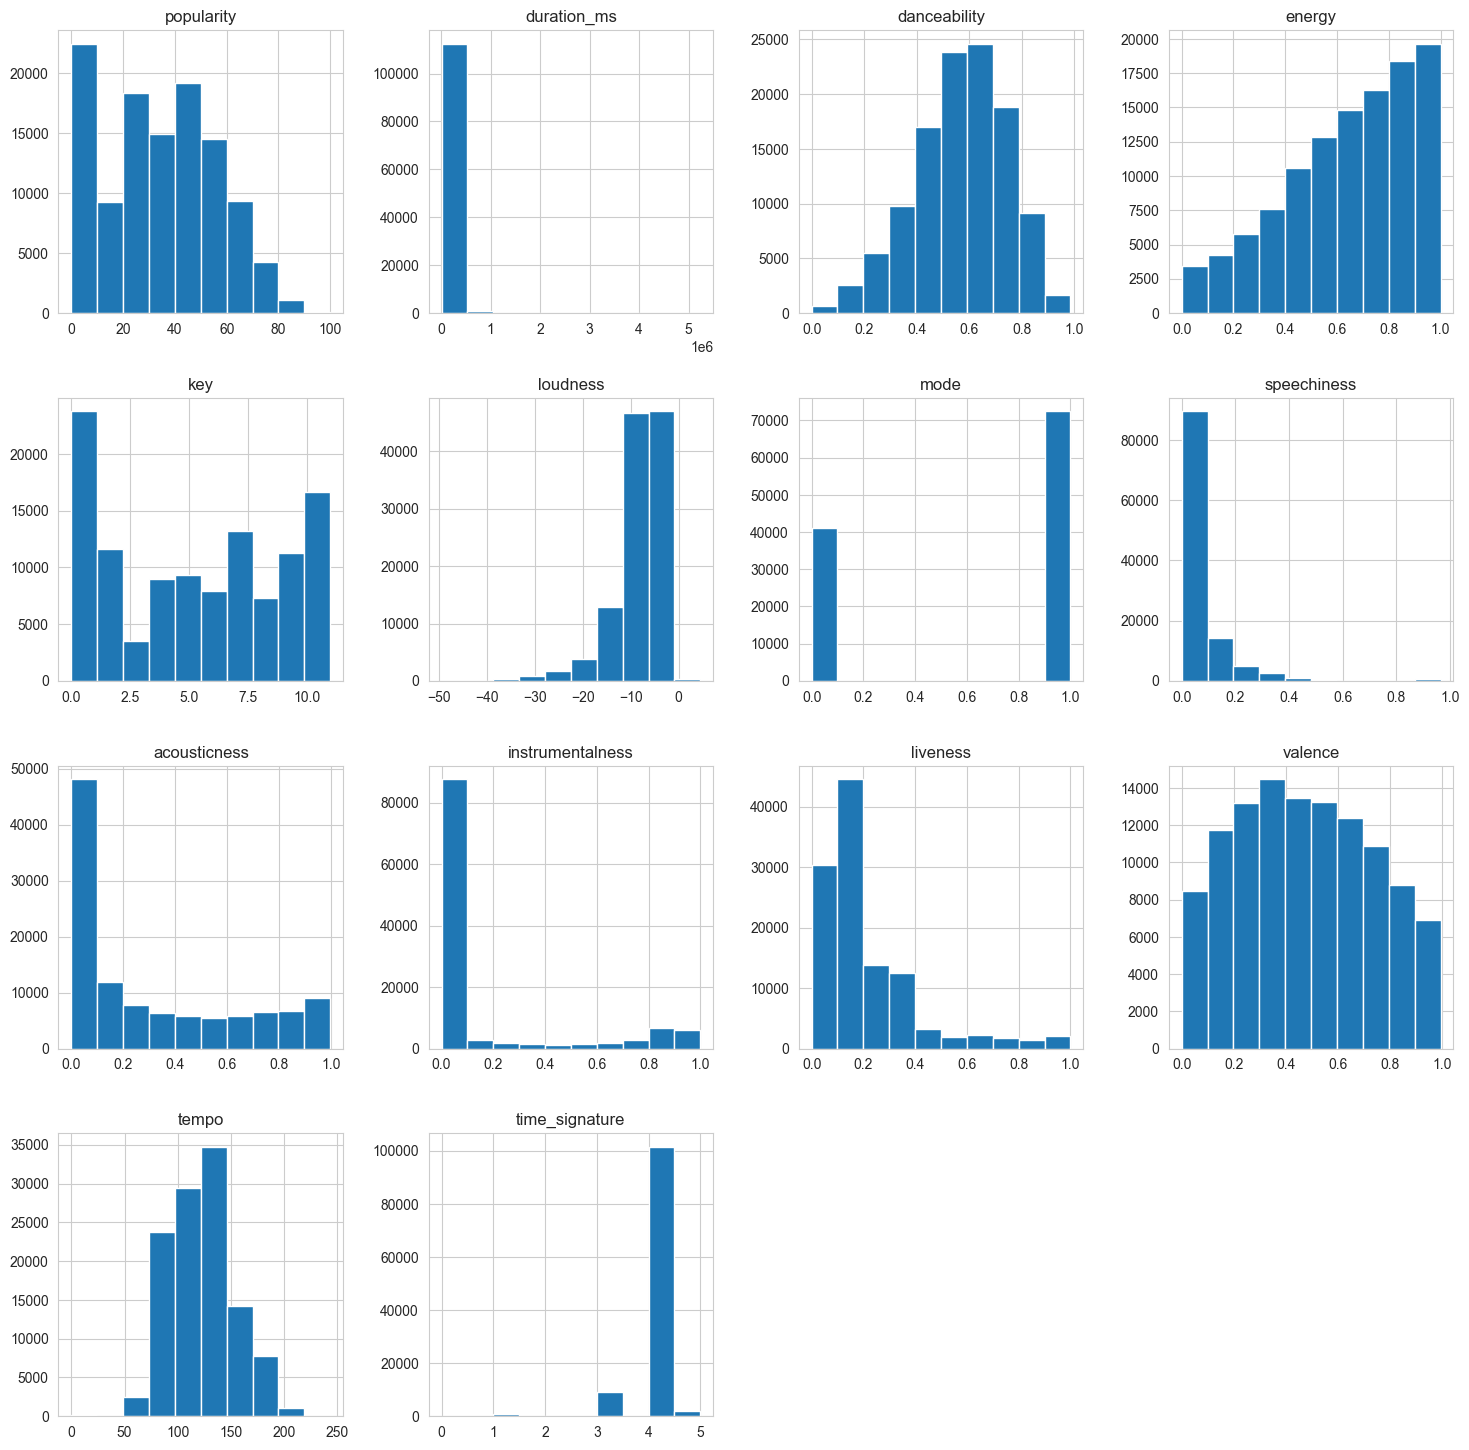

In [173]:
df.hist(figsize=(18,18))
plt.show()

We can see that most of the variables are not normally distributed.

Few relevant insights:
- From the "energy" histogram, we notice that songs tend to have higher levels of energy. The higher levels of energy observed in the histogram indicate that the analyzed songs in the dataset generally exhibit a greater sense of intensity, liveliness, and higher perceived activity. These songs are likely to have more energetic elements, such as a strong rhythm, prominent beats, and a more intense sound overall. However, it's important to consider that the energy attribute is a subjective measure and may vary based on individual perception and interpretation.
- Most of the tracks in the dataset have a speechiness value of 0, indicating a lack of spoken words or vocals in the music. Interestingly, instrumentalness, which measures the extent to which a track consists of instrumental sounds without any vocal content, also predominantly has a value of 0. The calculation methods for these metrics are not explicitly clear, as speechiness should represent the amount of text in songs, while instrumentalness should represent the amount of instrumental sound. However, it is worth noting that these two variables are not negatively correlated and exhibit similar distributions, which raises questions about their accurate representation and calculation methods They may not perfectly capture the nuances of speech or instrumental elements in every track.

We create a boxplot using the specified features:'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence'. We do not include variables such has tempo or loudness since, from the decriptive analytics, we noticed that they have a different range of values which are much higher than the others, whose values are mostly between 0 and 1.

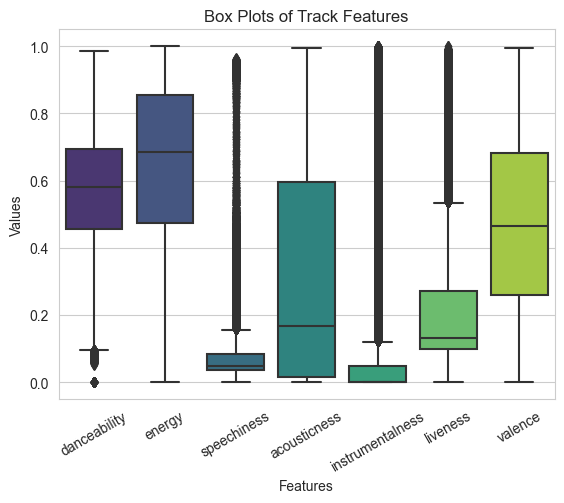

In [174]:
feat_1 = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

ax = sns.boxplot(data=df[feat_1], orient='v', palette='viridis')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Box Plots of Track Features')

plt.show()

The analysis of the box plots reveals that:
- both 'energy' and 'danceability' exhibit values that are predominantly above the average range.
- 'speechiness' and 'instrumentalness' have low values with several outliers.
- 'acousticness' shows a wide range of values, spanning from very low to over 0.5.

We create a histogram and kernel density estimate plot for the 'popularity' column, in order to visualize the distribution of popularity values.

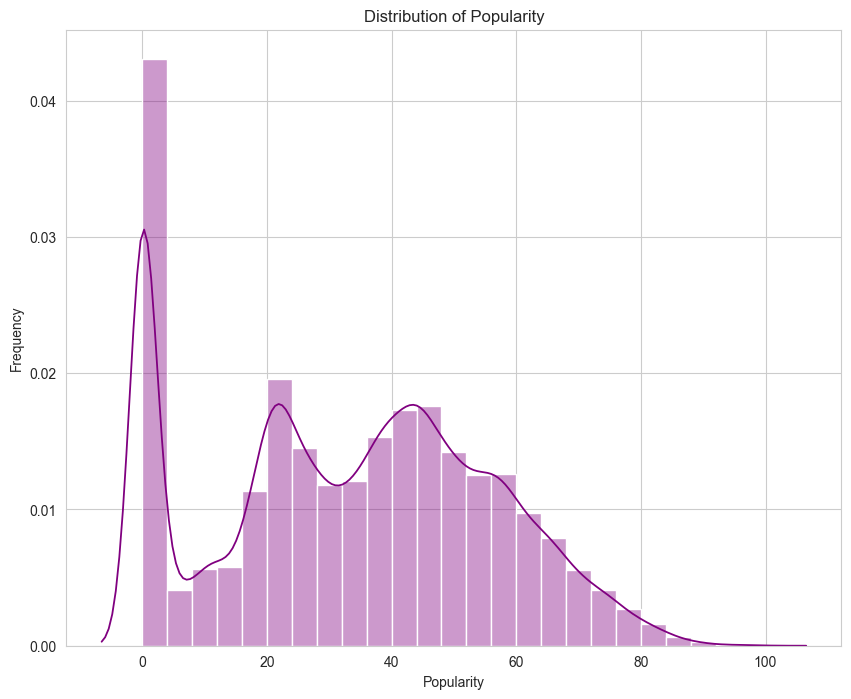

In [175]:
plt.figure(figsize = (10, 8))
sns.histplot(df['popularity'], bins=range(max(df['popularity'])+2), color = 'purple', alpha = 0.4, stat = 'density', binwidth = 4, edgecolor = 'white')
sns.kdeplot(df['popularity'], color = 'purple', alpha = 1, linewidth = 1.3)

plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')

plt.show()

The distribution of popularity in the dataset suggests that most songs tend to have average popularity ratings, while only a small portion of songs achieve a high level of popularity. The large number of songs with a popularity of 0 indicates that these tracks have not gained significant attention or recognition among listeners. This could be due to various reasons, such as being from lesser-known artists or simply not aligning with current popular trends. Additionally, factors like marketing, promotion, and playlist placements can heavily influence a song's popularity, and songs with limited visibility or accessibility may struggle to gain widespread popularity.

We display the top 5 artists per count in our dataset. 

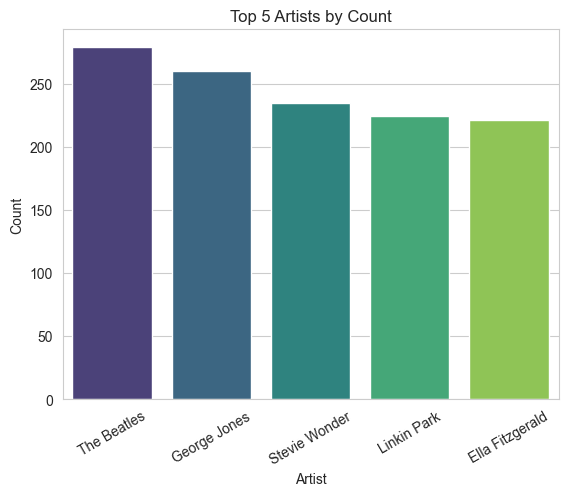

In [177]:
artists = df['artists'].value_counts().nlargest(5)

ax = sns.countplot(data = df, x="artists", order=artists.index, palette = 'viridis')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel('Artist')
ax.set_ylabel('Count')
ax.set_title('Top 5 Artists by Count')

plt.show()

The dataset indicates that The Beatles, George Jones, Stevie Wonder, Linkin Park, and Ella Fitzgerald are the most prominent artists based on the frequency of their appearances. They have been featured most frequently in the dataset, highlighting their prominence in the music's context.

We calculate the average popularity for each track_genre and get the first 10. Then, we plot a bar plot showing the top 10 genres ranked by average popularity.

In [178]:
avg_popularity = df.groupby('track_genre')['popularity'].mean()

top_10_genres = avg_popularity.sort_values(ascending=False).head(10)

print(top_10_genres)

track_genre
pop-film     59.280280
k-pop        56.963928
chill        53.704705
sad          52.379000
grunge       49.582583
indian       49.528529
anime        48.766767
emo          48.128000
pop          47.903323
sertanejo    47.866000
Name: popularity, dtype: float64


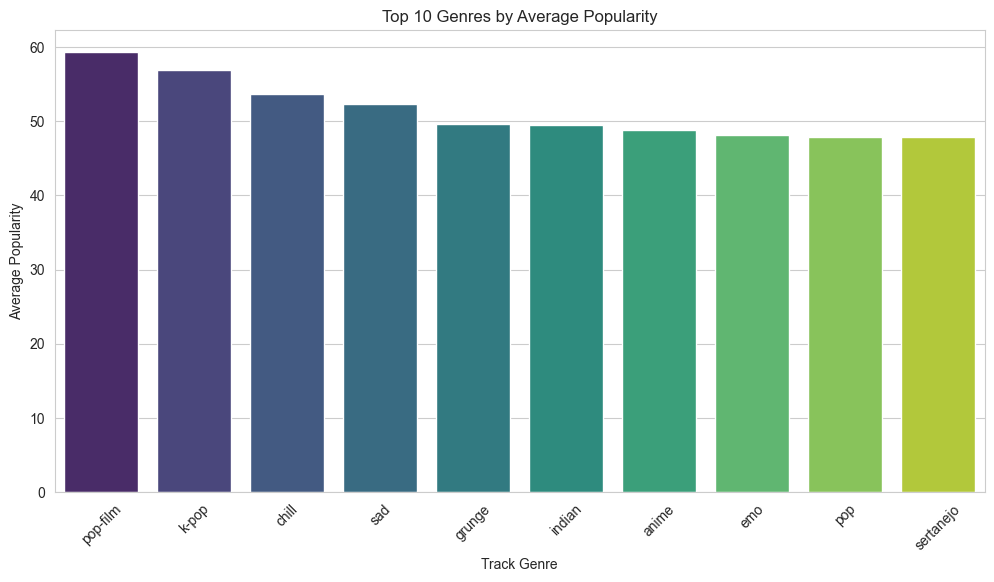

In [179]:
top_10_genres = top_10_genres.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='track_genre', y='popularity', data=top_10_genres, palette="viridis")
plt.xticks(rotation=45)
plt.title('Top 10 Genres by Average Popularity')
plt.xlabel('Track Genre')
plt.ylabel('Average Popularity')
plt.show()

The top 10 genres by average popularity in the dataset reveal that the audience has diverse and eclectic music tastes. Pop-film is the most popular genre, followed by K-Pop, chill music, and sad music.  Indian music and anime music also rank high, showing a preference for traditional and culturally significant music and music associated with Japanese media. What is surprising is the presence of Sertanejo music, a popular genre in Brazil, that also seems to have a significant following among the  audience.

We display the percentages of explicit and not explicit songs.

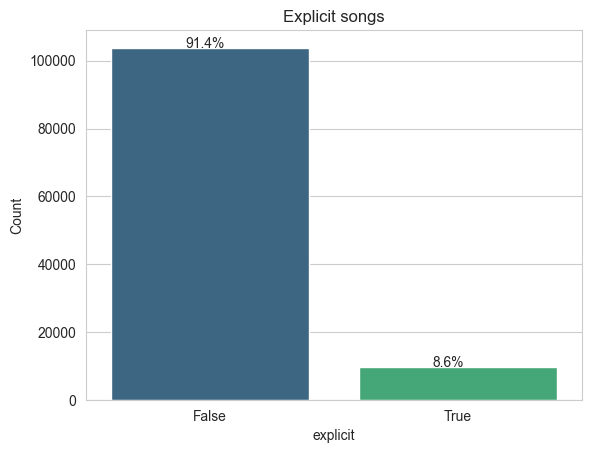

In [180]:
ax = sns.countplot(data=df, x="explicit", palette='viridis')

ax.set_xlabel('explicit')
ax.set_ylabel('Count')

ax.set_title('Explicit songs')

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.3, p.get_height()+10))

plt.show()

More than 90% of the songs in the dataset are not marked as explicit. This indicates that the vast majority of the songs are suitable for all audiences, without any explicit or mature content.

We divide the data into two subsets based on the 'mode' column (mode 0 and mode 1), calculate the average popularity for each key within each mode, and create a bar plot comparing the average popularity of keys for minor mode (mode 0) and major mode (mode 1) using subplots.

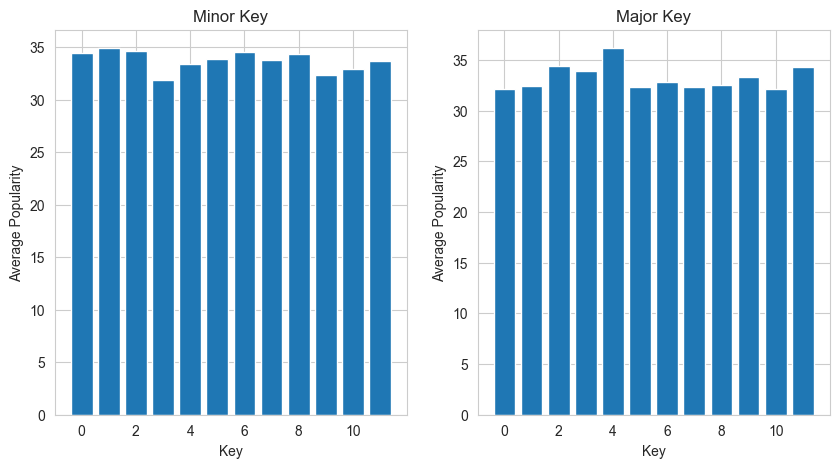

In [181]:
mode_0 = df[df['mode'] == 0]
mode_1 = df[df['mode'] == 1]

mode_0_pop = mode_0.groupby('key')['popularity'].mean().reset_index()
mode_1_pop = mode_1.groupby('key')['popularity'].mean().reset_index()

# Create the subplots
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Plot the average popularity for mode = 0
axs[0].bar(mode_0_pop['key'], mode_0_pop['popularity'])
axs[0].set_xlabel('Key')
axs[0].set_ylabel('Average Popularity')
axs[0].set_title('Minor Key')

# Plot the average popularity for mode = 1
axs[1].bar(mode_1_pop['key'], mode_1_pop['popularity'])
axs[1].set_xlabel('Key')
axs[1].set_ylabel('Average Popularity')
axs[1].set_title('Major Key')

# Show the plot
plt.show()

The analysis of popularity scores across different key signatures suggests that there is minimal variation in popularity between them. Usually, songs in a major key tend to have higher popularity scores because major keys tend to sound more upbeat and positive, which can lead to a more widespread appeal and popularity. However, in this case, songs in a minor key, that convey a more melancholic and emotional tone, are successful too.

# Data Pre Processing

Now, it is time to deal with the problem of reapeted track ids that, despite being supposed to be unique values, they are clearly repeated throughout the dataset.

In [182]:
df.nunique(axis = 0)

track_id            89740
artists             31437
album_name          46589
track_name          73608
popularity            101
duration_ms         50696
explicit                2
danceability         1174
energy               2083
key                    12
loudness            19480
mode                    2
speechiness          1489
acousticness         5061
instrumentalness     5346
liveness             1722
valence              1790
tempo               45652
time_signature          5
track_genre           114
is_popular              2
dtype: int64

In [183]:
df.shape

(113549, 21)

First, we count the occurrences of each unique track_id value, whose count is greater than 1.

In [268]:
track_id_counts = df['track_id'].value_counts()
track_id_filtered = df[df['track_id'].isin(track_id_counts[track_id_counts > 1].index)]
print(track_id_filtered['track_id'].value_counts())

6S3JlDAGk3uu3NtZbPnuhS    9
2kkvB3RNRzwjFdGhaUA0tz    8
2Ey6v4Sekh3Z0RUSISRosD    8
4aqS25F3ywJ9TGnNkOqilC    7
5ZsAhuQ24mWHiduaxJqnhW    7
                         ..
3LxG9HkMMFP0MZuiw3O2rF    2
1Ylkd7GPx0VpwHNlAGpig2    2
7uDjywLMNvTwD4WVYo9Yoh    2
03tp1TUFVJRt1HuWGlpRy8    2
2TgTGJyiWf1ptW5g3QG938    2
Name: track_id, Length: 16299, dtype: int64


We notice that many track_id values are present in the dataset multiple times. Therefore, in order to understand what differs we check for the differences in the other variables, we group the dataset by track_id and check for duplicates in every variable.

In [185]:
grouped = df.groupby('track_id')

duplicated_artists = grouped['artists'].nunique() > 1
print(f"Track_ids with different artists: {duplicated_artists.sum()}")

duplicated_album_name = grouped['album_name'].nunique() > 1
print(f"Track_ids with different album names: {duplicated_album_name.sum()}")

duplicated_track_name = grouped['track_name'].nunique() > 1
print(f"Track_ids with different track names: {duplicated_track_name.sum()}")

duplicated_popularity = grouped['popularity'].nunique() > 1
print(f"Track_ids with different popularity: {duplicated_popularity.sum()}")

duplicated_duration_ms = grouped['duration_ms'].nunique() > 1
print(f"Track_ids with different duration_ms: {duplicated_duration_ms.sum()}")

duplicated_explicit = grouped['explicit'].nunique() > 1
print(f"Track_ids with different explicitness: {duplicated_explicit.sum()}")

duplicated_danceability = grouped['danceability'].nunique() > 1
print(f"Track_ids with different danceability: {duplicated_danceability.sum()}")

duplicated_energy = grouped['energy'].nunique() > 1
print(f"Track_ids with different energy: {duplicated_energy.sum()}")

duplicated_key = grouped['key'].nunique() > 1
print(f"Track_ids with different key: {duplicated_key.sum()}")

duplicated_loudness = grouped['loudness'].nunique() > 1
print(f"Track_ids with different loudness: {duplicated_loudness.sum()}")

duplicated_mode = grouped['mode'].nunique() > 1
print(f"Track_ids with different mode: {duplicated_mode.sum()}")

duplicated_speechiness = grouped['speechiness'].nunique() > 1
print(f"Track_ids with different speechiness: {duplicated_speechiness.sum()}")

duplicated_acousticness = grouped['acousticness'].nunique() > 1
print(f"Track_ids with different acousticness: {duplicated_acousticness.sum()}")

duplicated_instrumentalness = grouped['instrumentalness'].nunique() > 1
print(f"Track_ids with different instrumentalness: {duplicated_instrumentalness.sum()}")

duplicated_liveness = grouped['liveness'].nunique() > 1
print(f"Track_ids with different liveness: {duplicated_liveness.sum()}")

duplicated_valence = grouped['valence'].nunique() > 1
print(f"Track_ids with different valence: {duplicated_valence.sum()}")

duplicated_tempo = grouped['tempo'].nunique() > 1
print(f"Track_ids with different tempo: {duplicated_tempo.sum()}")

duplicated_time_signature = grouped['time_signature'].nunique() > 1
print(f"Track_ids with different time_signature: {duplicated_time_signature.sum()}")

duplicated_genre = grouped['track_genre'].nunique() > 1
print(f"Track_ids with different genres: {duplicated_genre.sum()}")

Track_ids with different artists: 0
Track_ids with different album names: 0
Track_ids with different track names: 0
Track_ids with different popularity: 720
Track_ids with different duration_ms: 0
Track_ids with different explicitness: 0
Track_ids with different danceability: 0
Track_ids with different energy: 0
Track_ids with different key: 0
Track_ids with different loudness: 0
Track_ids with different mode: 0
Track_ids with different speechiness: 0
Track_ids with different acousticness: 0
Track_ids with different instrumentalness: 0
Track_ids with different liveness: 0
Track_ids with different valence: 0
Track_ids with different tempo: 0
Track_ids with different time_signature: 0
Track_ids with different genres: 16299


Looking at the output, we notice that some "track_id" may appear multiple times due to variations in either the popularity score or the assigned track genre. Specifically, each unique "track_id" actually represents a specific song with identical values for all variables except for "popularity" (in which there are 720 track_id with different popularity scores) or "track_genre" (in which there are 16299 track_id with different genres). Therefore, different rows with the same 'track_id' actually correspond to different popularity scores or genres assigned to the same song.

We are also interested in understanding if there are cases where both popularity and track_genre are different for the single track_id values.

In [186]:
duplicated_both = grouped.nunique()[['popularity', 'track_genre']].apply(lambda x: x.nunique(), axis=1) > 1
print(f"track_id with different genre and popularity: {duplicated_both.sum()}")

track_id with different genre and popularity: 15872


Because the track_id with different genre and popularity are 15872, it means that the majority of cases show that both the genre and popularity of a song are different, resulting in the repetition of track IDs multiple times.

Since there can be the same songs represented by different track ids due to their inclusion in different albums, we want to explore the variable album_name and eventually understand if popularity is influenced by the different album.

In order to do so, we have group the track_name with the artists variable, as the same song name might be used by different artists but only once by the same singer.

Therefore, we create a new dataset containing only track_ids, track_names, artists, album_name and track_genre.

In [187]:
cols = ['track_id', 'artists', 'track_name', 'album_name', 'popularity', 'track_genre']

df_check = pd.DataFrame(df[cols])

We filter the df_check to identify duplicate rows based on the 'artists' and 'track_name' columns, keeping all occurrences of duplicates in the resulting df dupl. This allows us to keep only those songs that are repeated but may differ in other columns.

In [188]:
dupl = df_check[df_check.duplicated(subset=['artists', 'track_name'], keep=False)]


We identify and select the duplicate rows in the dupl dataframe based on the combination of 'artists' and 'track_name', and then we remove any remaining duplicates within these selected rows based on the columns 'track_name', 'artists', and 'album_name'. In this way, we exclude those songs that are repeated due to reasons other than the album.

In [189]:
duplicate_counts = dupl.groupby(['artists', 'track_name']).size()
duplicates = dupl[dupl.set_index(['artists', 'track_name']).index.isin(duplicate_counts[duplicate_counts > 1].index)]
duplicates.drop_duplicates(subset=['track_name', 'artists', 'album_name'], keep=False, inplace=True)

In order to understand if popularity scores change according to the album, we first group duplicates by track_name and artists. Then, we assign a unique group number to each group of duplicates and we randomly select four unique group numbers. Finally, we select the corresponding groups of duplicates using isin and retrieve the examples.

In [ ]:
grouped_duplicates = duplicates.groupby(['track_name', 'artists'])

unique_groups = grouped_duplicates.ngroup()
selected_groups = unique_groups.sample(n=4).unique()
examples = duplicates[unique_groups.isin(selected_groups)]

examples[['track_name', 'artists', 'album_name', 'popularity']]

We observe that the popularity of a song is significantly influenced by the album in which it is originally released, with higher values typically associated with the original album.

However, despite these findings, we decide not to reduce the dataset by considering only one album per song. Instead, we will treat songs from different albums as distinct entities, as we want to avoid the potential loss of a significant amount of valuable data.

We move on to process the data for the clustering and regression analyses with a two-fold strategy:
- Firstly, we intend to generate a new column "genre" that lists the genres in a list format to eliminate the repetition of songs with multiple genres. This approach ensures that such songs appear only once with different genres. Subsequently, we will remove the original track_genre column.
- Secondly, we plan to replace the values of popularity for the same track_id with the maximum of the popularity for that specific track_id. This process preserves the unique popularity values for each song, while correcting the popularity values that are repeated and substituting them with the most realistic value.

In [269]:
df_sorted = df.sort_values(by='popularity', ascending=False)

# Group the dataframe by track_id and get the highest popularity and a list of all genres
grouped = df_sorted.groupby('track_id').agg({'popularity': 'first', 'track_genre': lambda x: list(set(x))})

# Rename the columns
grouped = grouped.rename(columns={'track_genre': 'genre'})

grouped['genre'] = grouped['genre'].apply(lambda x: ','.join(x))

# Reset the index
grouped = grouped.reset_index()

# Drop the duplicates of track_id, keeping the one with the highest popularity
result = grouped.drop_duplicates(subset=['track_id'], keep='first')

# Merge the result dataframe with the original dataframe on track_id
merged = pd.merge(df, result, on='track_id', how='inner')

We now have a new dataframe with the desired modifications. We drop the variables that we will not need anymore and then we export it as a new csv file, so that one can use the new dataset without having to rerun all the passages above.

In [270]:
merged = merged.reset_index(drop=True)
merged.drop(['track_genre', 'popularity_x'], axis=1, inplace=True)
merged = merged.rename(columns={'popularity_y': 'popularity'})
merged.drop_duplicates(inplace=True)
merged['genre'] = merged['genre'].apply(lambda x: x.split(','))
merged.to_csv('project_data_max.csv', index=False)

We start again with the new dataset.

In [4]:
data = pd.read_csv('project_data_max.csv')

In [193]:
data.head()

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,is_popular,popularity,genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,False,0.676,0.4610,1,-6.746,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,popular,73,"['singer-songwriter', 'acoustic', 'songwriter'..."
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,149610,False,0.420,0.1660,1,-17.235,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,popular,55,"['acoustic', 'chill']"
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,210826,False,0.438,0.3590,0,-9.734,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,popular,57,['acoustic']
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,False,0.266,0.0596,0,-18.515,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,popular,71,['acoustic']
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,False,0.618,0.4430,2,-9.681,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,popular,82,['acoustic']


We check again for duplicated values in case new ones arised.

In [272]:
# We check for duplicates.
dupl_counts = data.duplicated().sum()

if dupl_counts.sum() == 0:
    print('There are no duplicated values')
else:
    print(dupl_counts)

There are no duplicated values


We check for unique values.

In [195]:
data.nunique()

track_id            89740
artists             31437
album_name          46589
track_name          73608
duration_ms         50696
explicit                2
danceability         1174
energy               2083
key                    12
loudness            19480
mode                    2
speechiness          1489
acousticness         5061
instrumentalness     5346
liveness             1722
valence              1790
tempo               45652
time_signature          5
is_popular              2
popularity            101
genre                1576
dtype: int64

In [196]:
data.shape

(89746, 21)

Now, the number of unique track_id values in our dataset is equal to the total number of entries, indicating that each track has a unique identifier assigned to it.

# Descriptive Statistics on the new dataframe

Considering the modifications made to the dataset, it is essential to reevaluate the descriptive statistics to account for any potential changes and uncover new insights that may have arisen from our modifications.

We calculate descriptive statistics for the df and format each statistic as a float with a fixed number of decimal places.

In [197]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity
count,89746.000000,89746.000000,89746.000000,89746.000000,89746.000000,89746.000000,89746.000000,89746.000000,89746.000000,89746.000000,89746.000000,89746.000000,89746.000000,89746.000000
mean,229144.584884,0.562164,0.634466,5.283478,-8.498879,0.636998,0.087443,0.328270,0.173404,0.216988,0.469468,122.059328,3.897433,33.208756
std,112945.408964,0.176687,0.256603,3.559901,5.221413,0.480868,0.113275,0.338315,0.323841,0.194900,0.262863,30.117598,0.453423,20.573912
min,8586.000000,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,173040.000000,0.450000,0.457000,2.000000,-10.322000,0.000000,0.036000,0.017100,0.000000,0.098200,0.249000,99.264500,4.000000,19.000000
50%,213295.500000,0.576000,0.676000,5.000000,-7.185000,1.000000,0.048900,0.188000,0.000058,0.132000,0.457000,122.013500,4.000000,33.000000
75%,264293.000000,0.692000,0.853000,8.000000,-5.108000,1.000000,0.085900,0.625000,0.097550,0.279000,0.682000,140.077000,4.000000,49.000000
max,5237295.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000,100.000000


We can notice that song's features variables such has tempo or loudness have a different range of values which are much higher than the others, whose values are mostly between 0 and 1.

We plot a heatmap to display the correlation among variables.

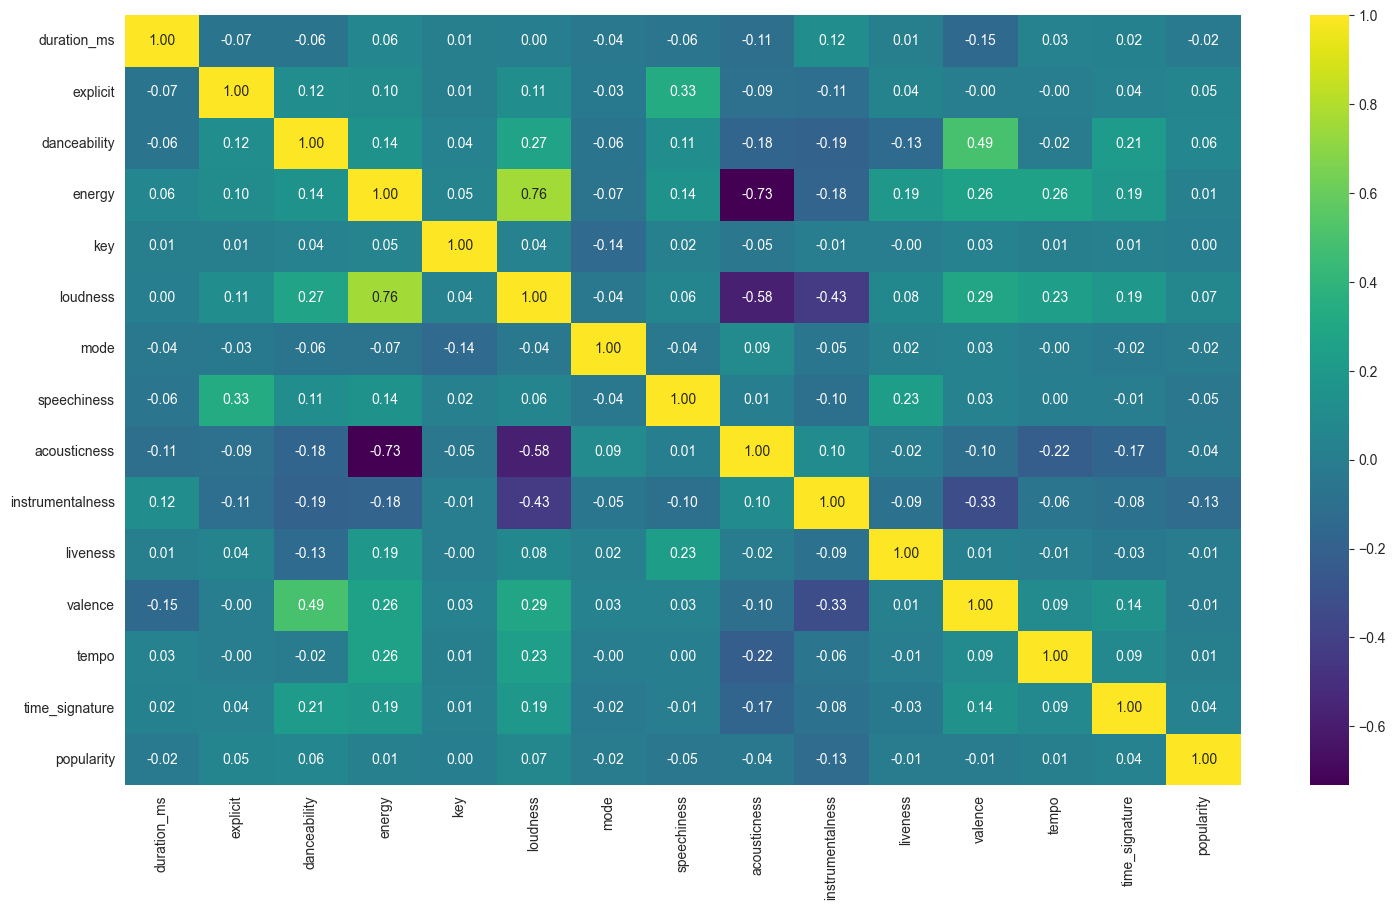

In [198]:
corr_data = data.corr()

plt.figure(figsize=(18, 10))
sns.heatmap(corr_data, cmap="viridis", annot=True, fmt=".2f")
plt.show()

In this case, the values have undergone slight changes, particularly concerning the correlations with popularity. However, these changes are minimal. Notably, the previously observed correlations between "acousticness"-"energy" and "loudness"-"energy" remain evident.

We create a histogram for each variable in the dataset, which shows the distribution of values for that variable.

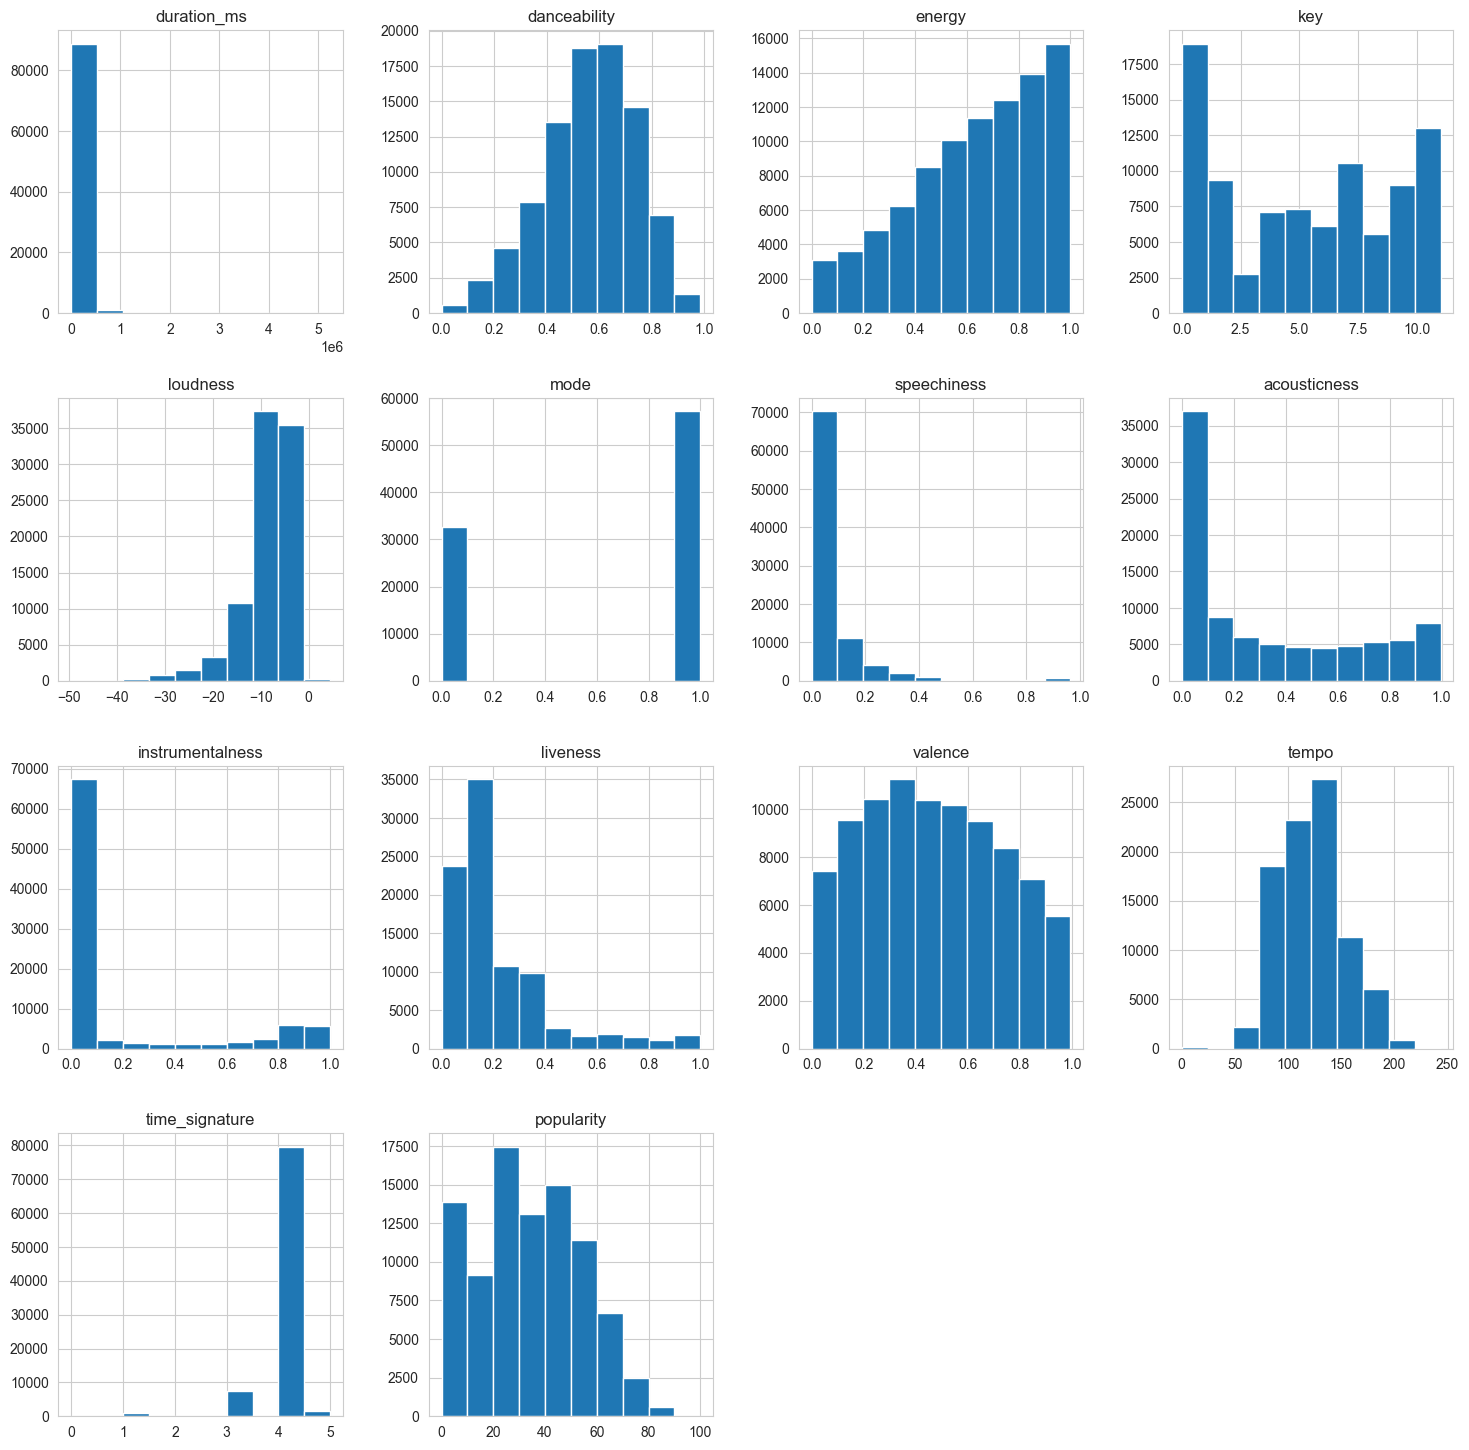

In [199]:
data.hist(figsize=(18,18))
plt.show()

The distributions of all the track features remain unchanged, which is expected as we did not modify them during our preprocessing steps. However, the fact that the distribution of the new 'popularity' column, created during the pre-processing stage, remains the same as the original 'popularity' column suggests that our pre-processing efforts have maintained the overall distribution of popularity scores. This indicates that we have been successful in preserving the essential characteristics of the original data while addressing the issue of multiple values for the same track IDs. It is a positive indication that our pre-processing steps have been effective in preserving the integrity of the data and ensuring consistency in the popularity scores.

We create a boxplot using the specified features:'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence'. We do not include variables such has tempo or loudness since, from the decriptive analytics, we noticed that they have a different range of values which are much higher than the others, whose values are mostly between 0 and 1.

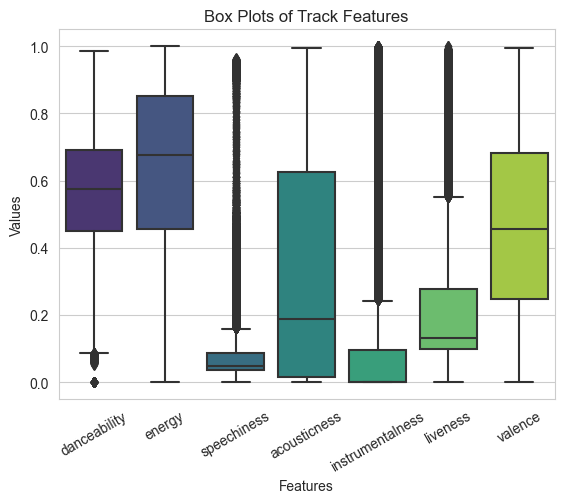

In [200]:
feat_1 = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

ax = sns.boxplot(data=data[feat_1], orient='v', palette='viridis')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Box Plots of Track Features')

plt.show()

The only noticeable difference in the boxplot is that the box for 'instrumentalness' is slightly larger, and the presence of outliers extends beyond 0.2.

We create a histogram and kernel density estimate plot for the 'popularity' column, in order to visualize the distribution of popularity values.

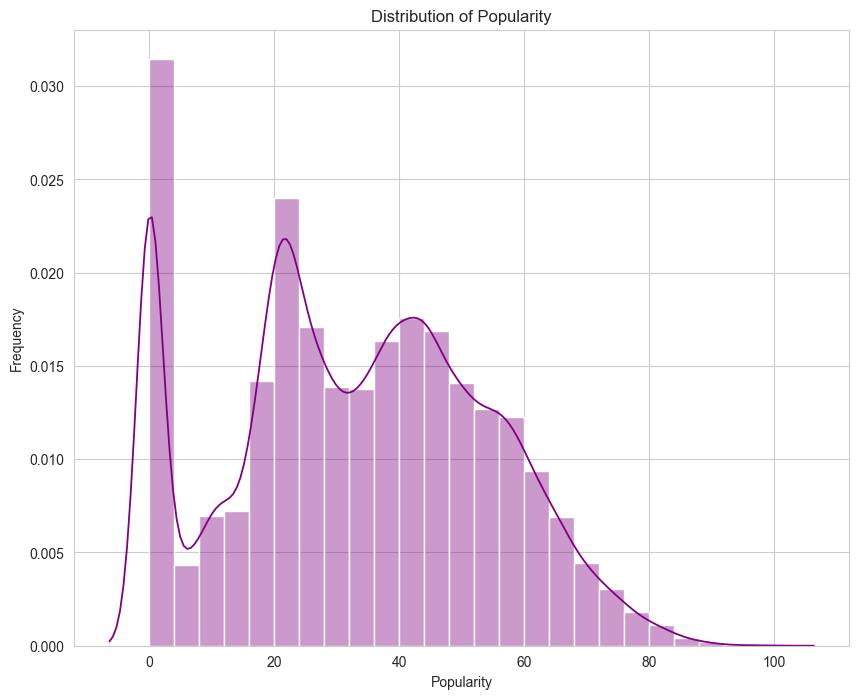

In [201]:
plt.figure(figsize = (10, 8))
sns.histplot(data['popularity'], bins=range(max(data['popularity'])+2), color = 'purple', alpha = 0.4, stat = 'density', binwidth = 4, edgecolor = 'white')
sns.kdeplot(data['popularity'], color = 'purple', alpha = 1, linewidth = 1.3)

plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')

plt.show()

As explained before, the distribution of popularity remains unchanged. Indeed, most songs still tend to have average popularity ratings, a large number of songs have 0 popularity and only a small portion of songs achieve a high level of popularity. 

To analyze the popularity distribution based on track features, we will create a new variable called 'is_popular'. This variable will have three classes: 'not_popular', 'moderately_popular', and 'very_popular'. Then, we create a plot  that visualizes the pairwise relationships between the features 'danceability', 'energy', 'speechiness', 'acousticness', and 'is_popular', using a scatterplot matrix. The data points are color-coded based on the 'is_popular' category, allowing for an analysis of how these features relate to the popularity classes.

We display the top 5 artists per count in our dataset. 


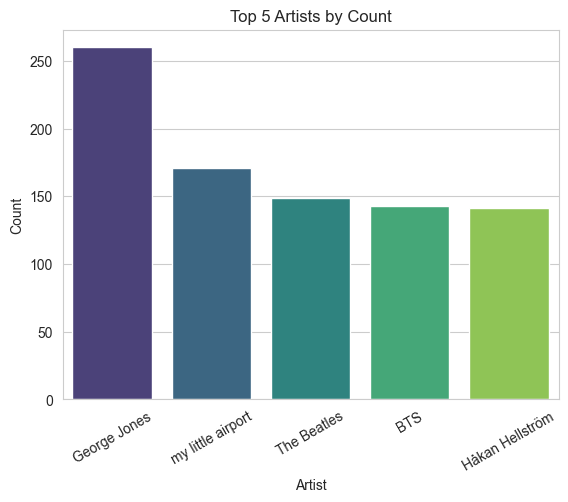

In [203]:
artists = data['artists'].value_counts().nlargest(5)

ax = sns.countplot(data = data, x="artists", order=artists.index, palette = 'viridis')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel('Artist')
ax.set_ylabel('Count')
ax.set_title('Top 5 Artists by Count')

plt.show()

The top five artists have changed, indicating that the previous result was heavily influenced by the repetitions of  IDs. This revised outcome is likely to be more accurate. Nonetheless, The Beatles and George Jones remain in the top five, alongside three new entries: BTS, My Little Airport, and Hakan Hellstrom.

- George Jones: an American country music singer and songwriter.
- My Little Airport: a Hong Kong-based indie band known for their alternative, lo-fi music style and sometimes satirical lyrics.
- The Beatles: an iconic English rock band.
- BTS: a South Korean boy band known for their energetic pop and hip-hop-infused sound.
- Håkan Hellström: a Swedish singer-songwriter known for his catchy pop-rock songs and heartfelt lyrics.

We calculate the average popularity for each track_genre and get the first 10. Then, we plot a bar plot showing the top 10 genres ranked by average popularity.

In [204]:
avg_popularity = data.groupby('genre')['popularity'].mean()

top_10_genres = avg_popularity.sort_values(ascending=False).head(10)

print(top_10_genres)

genre
['rock', 'alternative', 'pop', 'alt-rock']                              93.0
['rock', 'pop', 'piano', 'singer-songwriter', 'songwriter', 'r-n-b']    90.0
['singer-songwriter', 'pop', 'songwriter']                              90.0
['rock', 'pop', 'piano']                                                89.5
['latino', 'spanish']                                                   89.0
['indie', 'hip-hop']                                                    89.0
['house', 'progressive-house', 'pop', 'electro', 'dance']               89.0
['dance', 'soul', 'british']                                            87.0
['garage', 'indie', 'rock']                                             86.0
['pop', 'alternative']                                                  86.0
Name: popularity, dtype: float64


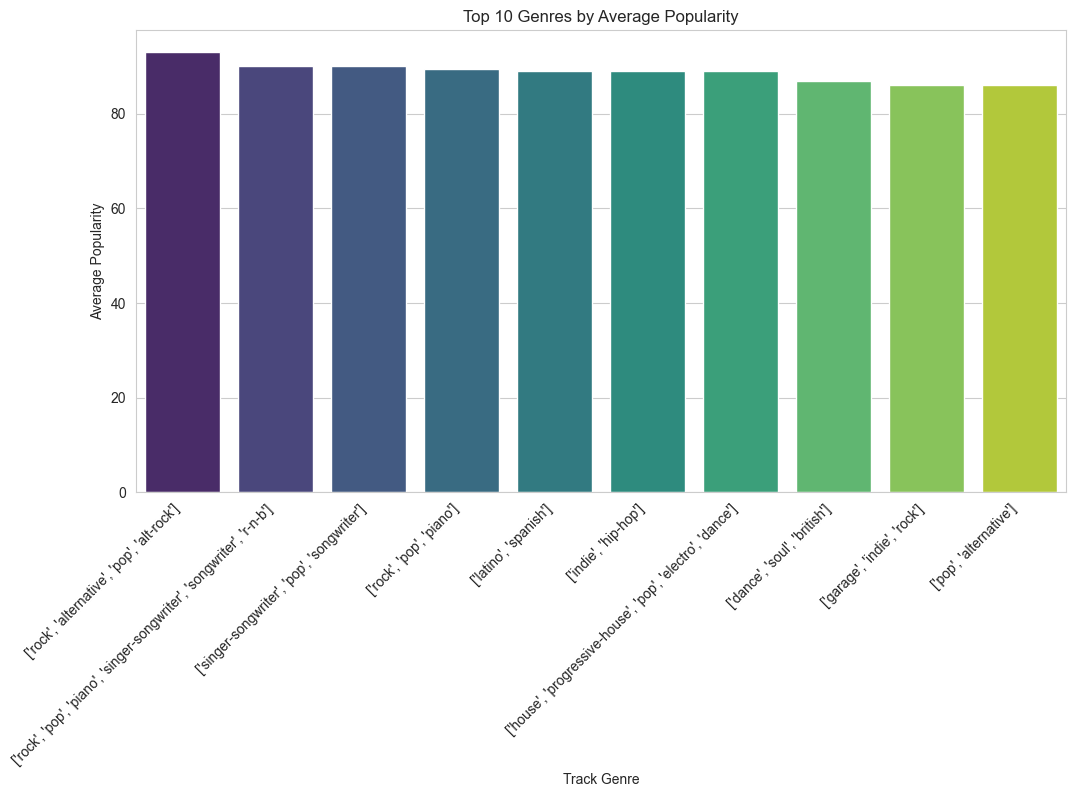

In [205]:
top_10_genres = top_10_genres.reset_index()

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='genre', y='popularity', data=top_10_genres, palette="viridis")
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')
plt.title('Top 10 Genres by Average Popularity')
plt.xlabel('Track Genre')
plt.ylabel('Average Popularity')
plt.show()

The top ten track genres have changed. The new top genres include a diverse range of styles such as 'piano', 'rock', 'pop', 'alt-rock', 'alternative', 'songwriter', 'singer-songwriter', 'r-n-b', 'house', 'dance', 'progressive-house', and 'electro'. This suggests a varied and eclectic taste in music among listeners. The inclusion of specific sub-genres like 'piano' and 'progressive-house' may reflect emerging trends or evolving preferences within the music industry.

We display the percentages of explicit and not explicit songs.

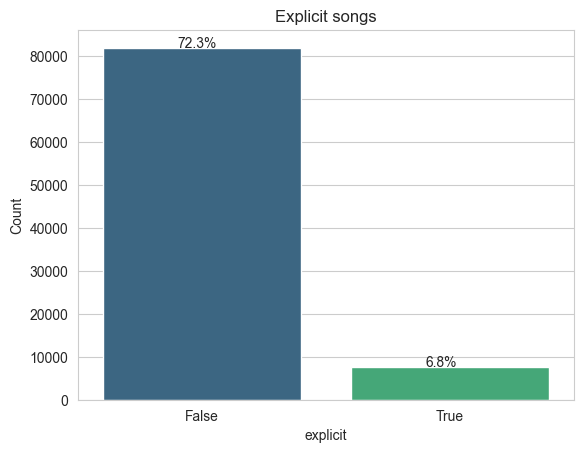

In [206]:
ax = sns.countplot(data=data, x="explicit", palette='viridis')

ax.set_xlabel('explicit')
ax.set_ylabel('Count')

ax.set_title('Explicit songs')

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.3, p.get_height()+10))

plt.show()

The percentages have slightly changed, but this is obvious since we have a different total number of songs. However, the majority of the songs still remain non-explicit, indicating that most of the songs are suitable for all audiences.

We divide the data into two subsets based on the 'mode' column (mode 0 and mode 1), calculate the average popularity for each key within each mode, and create a bar plot comparing the average popularity of keys for minor mode (mode 0) and major mode (mode 1) using subplots.

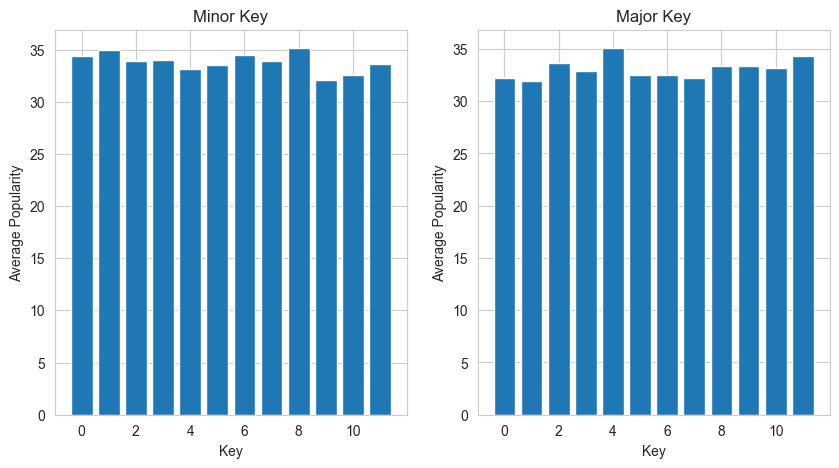

In [207]:
mode_0_data = data[data['mode'] == 0]
mode_1_data = data[data['mode'] == 1]

mode_0_popularity = mode_0_data.groupby('key')['popularity'].mean().reset_index()
mode_1_popularity = mode_1_data.groupby('key')['popularity'].mean().reset_index()

# Create the subplots
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Plot the average popularity for mode = 0
axs[0].bar(mode_0_popularity['key'], mode_0_popularity['popularity'])
axs[0].set_xlabel('Key')
axs[0].set_ylabel('Average Popularity')
axs[0].set_title('Minor Key')

# Plot the average popularity for mode = 1
axs[1].bar(mode_1_popularity['key'], mode_1_popularity['popularity'])
axs[1].set_xlabel('Key')
axs[1].set_ylabel('Average Popularity')
axs[1].set_title('Major Key')

# Show the plot
plt.show()

The analysis of popularity scores across different key signatures has remained almost unchanged, suggesting that there is minimal variation in popularity regarding the key used.

# Splitting, Encoding and Scaling

We now split the dataset into training and test set.

In [5]:
data.drop(['track_id', 'track_name', 'explicit', 'is_popular'], axis = 1, inplace = True)
data['genre'] = data['genre'].apply(literal_eval)

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

We use different types of encoding for the variables genre, artists and album_name.

For the variable genre, we use a Multi Label Binarizer, a variation of One-Hot Encoding. In this way, becuase the variable genre is a list of values, we are able to express all the values in the list as 1s, for every observation.

In [7]:
mlb = MultiLabelBinarizer()

# Encode the genre variable as dummy variables for both train and test sets
train_genres_encoded = pd.DataFrame(mlb.fit_transform(train['genre']), columns=mlb.classes_)
test_genres_encoded = pd.DataFrame(mlb.transform(test['genre']), columns=mlb.classes_)

# Reset the index of the encoded genre dataframes
train_genres_encoded = train_genres_encoded.set_index(train.index)
test_genres_encoded = test_genres_encoded.set_index(test.index)

# Concatenate the encoded genres with the original dataframes
train_encoded = pd.concat([train.drop('genre', axis=1), train_genres_encoded], axis=1)
test_encoded = pd.concat([test.drop('genre', axis=1), test_genres_encoded], axis=1)

Then, we use Leave One Out Encoding for the variables artists and album_name. We use the variable "popularity" to compute the mean, as we decided it best to use the target variable.

In [8]:
encoder = ce.LeaveOneOutEncoder(cols=['artists', 'album_name'])

# Fit and transform the training set
train_encoded_art = encoder.fit_transform(train_encoded, train_encoded['popularity'])

# Transform the test set using the fitted encoder
test_encoded_art = encoder.transform(test_encoded)

Now, we create the datasets X_train, y_train, X_test, y_test

In [9]:
X_train = train_encoded_art.drop('popularity', axis=1)
y_train = train_encoded_art['popularity']
X_test = test_encoded_art.drop('popularity', axis=1)
y_test = test_encoded_art['popularity']

We proceed with the scaling of the numerical variables. To do so, we decided to use a Standard Scaler.

In [10]:
# Define the columns to be scaled, which are the numerical ones
num_col = X_train.columns[2:15]

scaler = StandardScaler()

# Fit and transform the scaling on the specified columns of the training data
X_train_scaled = X_train.copy()
X_train_scaled[num_col] = scaler.fit_transform(X_train[num_col])

# Transform the scaling on the specified columns of the test data
X_test_scaled = X_test.copy()
X_test_scaled[num_col] = scaler.transform(X_test[num_col])

# K-Means Clustering

## Full Dataset

The first step of the analysis is clustering. We will first use the K-Means clustering on the entire dataset, although we will only include the track features (thus also excluding the popularity variable).

The clustering will have the K as the number of unique genre values.

We select the song features

In [274]:
data_clust = data.iloc[:, 4:18]

In [279]:
scaler = StandardScaler()

# Fit and transform the scaling on the data
scaler.fit(data_clust)

# Apply standard scaling to the data
data_clust_scaled = scaler.transform(data_clust)

We now set the number of clusters, and then we implement the clustering on the new dataset

In [280]:
K = 114
kmeans = KMeans(n_clusters = K, random_state = 42).fit(data_clust)

After the clustering, we add a new column called 'cluster', where we will include for every data point the cluster it has been assigned to.

In [281]:
data_clust['cluster'] = kmeans.predict(data_clust)

Then, we print the clusters and the number of data points in them

In [282]:
cluster_counts = data_clust['cluster'].value_counts().sort_values(ascending=False)
print(cluster_counts)

104    2290
71     2275
100    2238
0      2200
61     2192
       ... 
95        1
2         1
26        1
36        1
85        1
Name: cluster, Length: 114, dtype: int64


Although there are many cluster which have a high number of data points in them, there are also many with only few

### Silhouette Score

We will use the Silhouette Score to determine the quality of the clustering.
The score ranges from -1 to 1, with values closer to 1 indicating better clustering quality and values closer to -1 indicating poor clustering quality, while a score of 0 indicates overlapping clusters.

In [283]:
silhouette_score(data_clust, kmeans.labels_)

0.5206629133874716

A Silhouette score of 0.520 indicates a moderate level of clustering quality. There might still be some overlapping clusters, but overall the clusters are delineated.

## On X_train

We are curious to understand whether a smaller sample might produce better results. Therefore, we take the X_train dataset, which we have created above, and fit the clustering on it.

We firstly create the new dataframe called clust, from which we will implement the clustering, that presents all the variables we will need.

In [10]:
clust = X_train.iloc[:, 2:15]

We set the K to the number of unique track_genre values, which we now it is 114 from the df.nunique() at the beginning, and then we implement the clustering.

In [11]:
K = 114
kmeans = KMeans(n_clusters = K, random_state = 42).fit(clust)

/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


We add a column indicating the cluster each observation in the dataset has been assigned to.

In [12]:
clust['cluster'] = kmeans.predict(clust)

We now want to look at the distribution of the observations withing the clusters

In [13]:
cluster_counts = clust['cluster'].value_counts().sort_values(ascending=False)
print(cluster_counts)

53     2156
27     2155
11     2115
101    2024
81     2022
       ... 
24        1
68        1
77        1
47        1
108       1
Name: cluster, Length: 114, dtype: int64


We see again that despite there being many clusters with a high number of data points belonging to them, there is an equally high number of clusters that have very low values, many even lower than 10. We suspect that 114 clusters might be too high a value, as many data points that were in separated clusters might have easily been grouped into one or into other clusters, and forcing a specific number might have had an impact on this result. However, it seems that, from these track features alone, it is difficult to delineate a specific genre, because there are is definetely some bias in the classification of songs into genres, especially as we have noticed in the analyses above, where multiple songs were considered as different genres.

Moving on, we calculate the quality of the clustering with the Silhouette Method.

In [14]:
silhouette_score(clust, kmeans.labels_)

0.5166942076448896

A silhouette score of 0.517 indicates a moderate level of clustering quality. It seems that having a smaller sample not only did not produce a better clustering, but it even reduced the quality.

However, obtaining a suboptimal result with clustering for inferring the genre of a track is not surprising because clustering may not be the best choice for this task due to the subjective nature of genres, complex musical characteristics, and the need for contextual understanding.

# Regression Analysis

Predicting the popularity of a song allows various stakeholders to optimize their decision-making processes, invest resources wisely, and enhance the overall success and impact of music releases.
Record labels, music producers, and artists are often interested in predicting the popularity of a song to guide their marketing and promotional strategies, as by understanding which songs are likely to become popular, they can allocate their resources effectively, or they have a clearer idea of which songs (and artists) should be more or less promoted.

Moreover, because the music industry is highly competitive, businesses within this industry, such as record labels, streaming platforms, and music distributors, rely on accurate predictions of song popularity to make strategic decisions and maximize their financial returns.

We will use different kinds of algorithms to try and predict the song popularity. For every model, we will evaluate it with the R-Squared and the Root Mean Square Error.

We chose the R-Squared for two main reasons: first, interpretability of the results, which is pretty straight-forward, and second to understand exactly how well the regression model fits the observed data.

However, because we know that R-Squared might have some limitations, we thought it best to use it in conjunction with another metric, and we chose the Root Mean Square Error. Again, the reason is two-fold: on one hand, we use the RMSE because it has the same unit of measurement as the target variable, meaning it is easier and more immediate to interpret, on the other hand, because it calculates how close the prediction is to the actual value (on average).

### Linear Regression

First, we will try a simple Linear Regression, in order to set the baseline for the other models to compare them to.

In [11]:
# We fit the linear regression model on the training set
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_pred_tr_lr = lr.predict(X_train_scaled)

# Make predictions on the test set
y_pred_lr = lr.predict(X_test_scaled)

Now, we evaluate the model with the chosen metrics, R2 and RMSE

In [12]:
print("R2 train: ", r2_score(y_train, y_pred_tr_lr))
print("R2 test: ", r2_score(y_test, y_pred_lr))

print("rMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, y_pred_tr_lr)))
print("rMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))

R2 train:  0.6890721276547573
R2 test:  0.6508857319589539
rMSE train:  11.474993290092039
rMSE test:  12.143859157135369


The linear regression model demonstrates moderate performance in predicting the target variable.

The R2 value indicates the proportion of the variance in the dependent variable (target variable) that is explained by the linear regression model. In this case, the model explains approximately 68.9% of the variance in the training data and 65.1% of the variance in the test data. The R2 values are reasonably close, suggesting that the model generalizes well to unseen data.

The RMSE values of 11.47 for the train set and 12.14 for the test set indicate that, on average, the predicted values deviate from the actual values by approximately 11.47 and 12.14 units, respectively. While the RMSE values are not exceptionally low, they suggest a reasonable level of predictive performance. Despite the fact that the test set RMSE is slightly higher than the training set RMSE, the difference is minimal. Thus, it looks like the model is solid against overfitting.

We now plot the distribution of the actual values compared to the predicted ones.

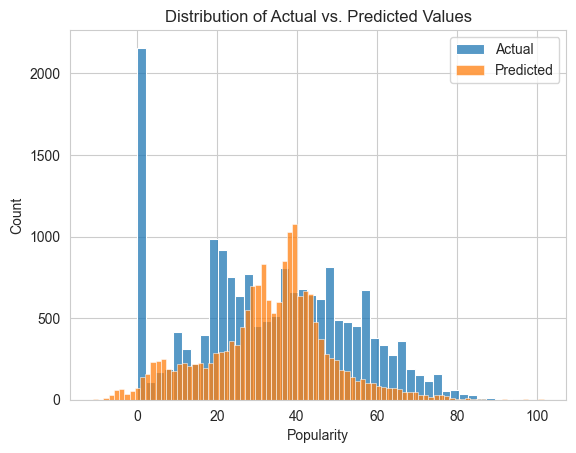

In [237]:
sns.histplot(y_test, label="Actual")
sns.histplot(y_pred_lr, label="Predicted")
plt.xlabel("Popularity")
plt.title("Distribution of Actual vs. Predicted Values")
plt.legend()
plt.show()

The predicted values slightly follow the distribution of the actual ones, although their peaks are in different spots.

### Decision Tree Regressor

We know that Linear Regression, due to its assumptions of linearity, is not enough as a model for our dataset.
Therefore, we move on to algorithms which are better suited for capturing nonlinear relationships between features and the target variable.

We first start with a Decision Tree Regressor

Before fitting the model, we try a grid search, to find the best hyperparameters that might give us the highest metrics.

In [ ]:
tree_reg = DecisionTreeRegressor(random_state=42)

# Set up a dictionary of parameters to try
param_grid = {
    'max_depth': [8, 10, 12, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2']
}

# Set up a grid search with cross-validation
grid_search = GridSearchCV(
    estimator=tree_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best estimator with the tuned hyperparameters
best_tree_reg = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

In [14]:
dt = DecisionTreeRegressor(max_depth = 15, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 2, random_state = 42)
# Fit the model on the training set
dt.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_tr_dt = dt.predict(X_train_scaled)

# Predict on the test set
y_pred_dt = dt.predict(X_test_scaled)

In [15]:
print("R2 train: ", r2_score(y_train, y_pred_tr_dt))
print("R2 test: ", r2_score(y_test, y_pred_dt))

print("rMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, y_pred_tr_dt)))
print("rMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt)))

R2 train:  0.5875579489828111
R2 test:  0.5421835531874646
rMSE train:  13.216123298021992
rMSE test:  13.906524897309676


The decision tree regressor model shows moderate performance in predicting the target variable.

The train R2 value of 0.588 and the test R2 value of 0.542 indicate that approximately 58.9% and 54.2% of the variance in the target variable can be explained by the decision tree model's predictions, respectively. This indicates a moderate to low level of fit to the test data.

The RMSE values of 13.22 for the train set and 13.91 for the test set indicate that, on average, the predicted values deviate from the actual values by approximately 13.22 and 13.91 units, respectively. These moderate RMSE values suggest that the model does not predict very well the popularity. However, train and test RMSE  are very similar, meaning that the model looks robust against overfitting.

We now plot the distribution of the actual values compared to the predicted ones.

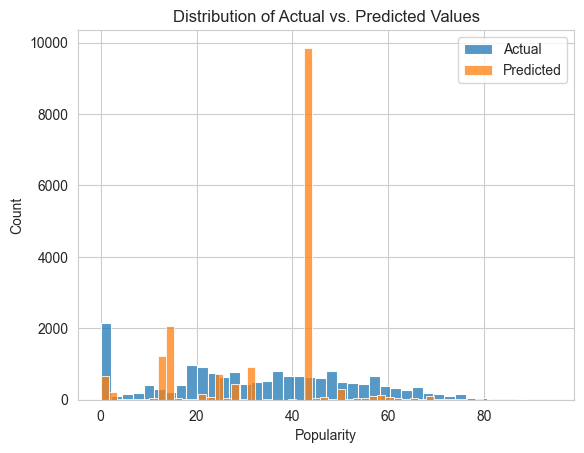

In [243]:
sns.histplot(y_test, label="Actual")
sns.histplot(y_pred_dt, label="Predicted")
plt.xlabel("Popularity")
plt.title("Distribution of Actual vs. Predicted Values")
plt.legend()
plt.show()

It is clear that the model predicts a high number of popularity values that are placed at more than 40, which is probably the reason as to why the performance of this model is so poor.

### Random Forest Regressor

In [ ]:
param_grid = {
    'n_estimators': [20, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 20],
    'max_features': ['sqrt', 'auto'],
    'max_leaf_nodes': [None, 5, 10, 20]
}

# define the random forest regressor model
rf_model = RandomForestRegressor(random_state = 42)

# define the grid search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# get the best model from the grid search
best_rf_model = grid_search.best_estimator_

print("Best Parameters: ", grid_search.best_params_)

In [16]:
rf = RandomForestRegressor(max_depth=15, max_features='auto', min_samples_split=10, n_estimators=100)

# Train the model on the training data
rf.fit(X_train_scaled, y_train)

# Predict on the training and test data
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [17]:
print("R2 train: ", r2_score(y_train, y_train_pred_rf))
print("R2 test: ", r2_score(y_test, y_test_pred_rf))

print("Training RMSE: ", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_rf)))
print("Test RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_rf)))

R2 train:  0.8104690944110721
R2 test:  0.7326500614735466
Training RMSE:  8.959063846635654
Test RMSE:  10.627055941630775


The random forest regressor model shows good performance in predicting the target variable.

In this case, the model explains approximately 81.1% of the variance in the training data and 73.3% of the variance in the test data. The R2 values are relatively close to 1, indicating that the model generalizes well to unseen data.

The RMSE on the training set is 8.96, while the RMSE on the test set is 10.63. The test set RMSE is slightly higher than the training set RMSE, which suggests that the model may be slightly overfitting the training data.

We plot the distribution of the actual values compared to the predicted ones.

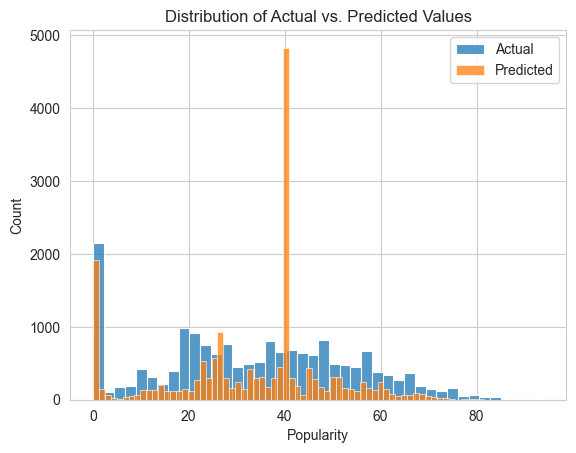

In [246]:
sns.histplot(y_test, label="Actual")
sns.histplot(y_test_pred_rf, label="Predicted")
plt.xlabel("Popularity")
plt.title("Distribution of Actual vs. Predicted Values")
plt.legend()
plt.show()

Almost as in decision tree, Random forest predicts many popularity values as around 40. There might be some bias in the data which leads to this result.

From Random Forest, we also plot the feature importance plot.

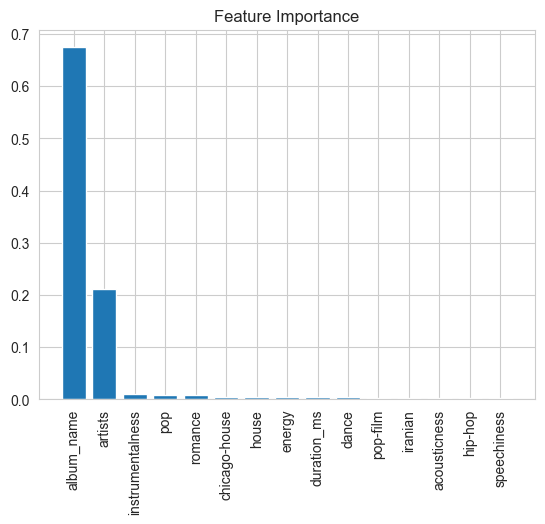

In [249]:
importances = rf.feature_importances_

# get the indices of the 15 most important features
indices = np.argsort(importances)[::-1][:15]
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=90)
plt.title('Feature Importance')
plt.show()

We notice that album_name is by far the most important variable. Based on the analyses we have done before, it is not surprising, as the albums really looked like they had an impact on the popularity of a song. What is interesting, though, is that we would have expected the artists to have been more relevant, but it is clearly not the case.

### Gradient Boosting

We do a random search, because a grid search was too computationally expensive

In [ ]:
# In this case we do a Random Search
params = {
    'n_estimators': sp_randint(50, 200),
    'learning_rate': sp_uniform(0.01, 0.5),
    'max_depth': sp_randint(2, 5),
    'min_samples_split': sp_randint(2, 9),
    'min_samples_leaf': sp_randint(1, 4),
    'max_features': ['auto', 'sqrt'],
    'subsample': sp_uniform(0.8, 0.2)
}

gb = GradientBoostingRegressor()

# We set up the random search with 5-fold cross-validation.
random_search = RandomizedSearchCV(gb, param_distributions=params, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# We fit the random search to the training data.
random_search.fit(X_train_scaled, y_train)

# We get the best hyperparameters and the best score.
best_params = random_search.best_params_

print("Best hyperparameters:", best_params)

Now that we have the hyperparameters, we fit the model

In [18]:
# We train the model on the training data with the best hyperparameters.
gb = GradientBoostingRegressor(learning_rate=0.38366005506869044, max_depth=4, max_features='auto',
                               min_samples_leaf=2, min_samples_split=2, n_estimators=173, subsample=0.8551998364045087)

# We fit the model on the training set.
gb.fit(X_train_scaled, y_train)

# We evaluate the model on training data.
y_pred_train_gb = gb.predict(X_train_scaled)

r2_train = r2_score(y_train, y_pred_train_gb)
rmse_train = mean_squared_error(y_train, y_pred_train_gb, squared=False)

# We evaluate the model on the test data.
y_pred_gb = gb.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_gb)
rmse = mean_squared_error(y_test, y_pred_gb, squared=False)

/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the p

/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the p

/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the p

/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the p

/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the p

/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the p

In [19]:
print("R2 train:", r2_train)
print("R2 test:", r2)
print("rMSE train:", rmse_train)
print("rMSE test:", rmse)

R2 train: 0.8479043271735649
R2 test: 0.7951480523490482
rMSE train: 8.025665260535064
rMSE test: 9.302356327096684


The gradient boosting regressor model demonstrates good performance in predicting the target variable.

The R-squared value of 0.848 for the training set indicates that approximately 84.8% of the variance in the target variable can be explained by the model's predictions. Similarly, the R-squared value of 0.798 for the test set suggests that around 79.8% of the variance can be explained. Since values are close to 1, this indicates a good fit of the model to the data.

The RMSE values of 8.012 for the training set and 9.247 for the test set indicate that, on average, the predicted values deviate from the actual values by approximately 8.012 and 9.247 units, respectively. These values indicate that the gradient boosting regressor model is capturing a significant portion of the data's variability and providing reasonably accurate predictions. However, the test set RMSE is slightly higher than the training set RMSE, which suggests that the model may be slightly overfitting the training data.

We now look at the distribution of the actual and predicted values

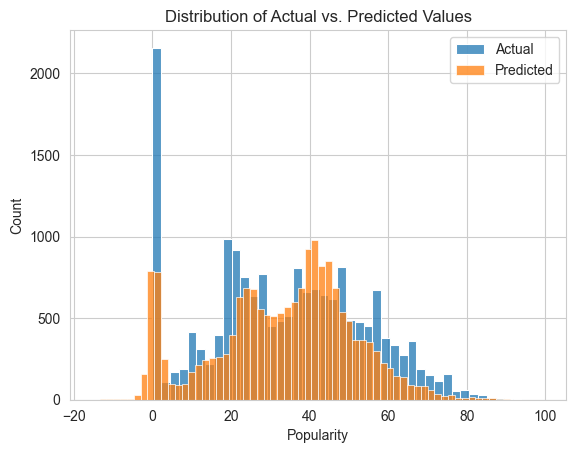

In [287]:
sns.histplot(y_test, label="Actual")
sns.histplot(y_pred_gb, label="Predicted")
plt.xlabel("Popularity")
plt.title("Distribution of Actual vs. Predicted Values")
plt.legend()
plt.show()

This model follows much more the distribution of the actual values, even considering the peak at the 0. This is definitely an improvement, considering the random forest plot.

### Voting Regressor

In [20]:
# Define the base models
model1 = RandomForestRegressor(max_depth=15, max_features='auto', min_samples_split=10, n_estimators=100)
model2 = LinearRegression()
#model3 = DecisionTreeRegressor()

# Define the voting regressor
voting_regressor = VotingRegressor(estimators=[('rf', model1), ('lr', model2)])

# Train the voting regressor on the training data
voting_regressor.fit(X_train_scaled, y_train)
y_pred_tr_vr = voting_regressor.predict(X_train_scaled)

# Evaluate the voting regressor on the test data
y_pred_vr = voting_regressor.predict(X_test_scaled)

/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [21]:
print("R2 train: ", r2_score(y_train, y_pred_tr_vr))
print("R2 test: ", r2_score(y_test, y_pred_vr))

print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_tr_vr)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_vr, squared=False)))

R2 train:  0.7814775380811323
R2 test:  0.7226533143902579
Training RMSE:  9.619902161677944
Test RMSE:  3.2899720339799354


The voting regressor model demostrates strong performance in predicting the target variable.

The voting regressor shows relatively good performance in terms of the R2 values on both the training and test sets. It explains approximately 78.1% of the variance in the training data and 72.2% of the variance in the test data. This suggests that the model captures a substantial portion of the target variable's variability.

There is a notable difference between the training and test set performance, particularly in terms of RMSE. The lower test set RMSE of 3.29 compared to the training set RMSE of 9.62 suggests that the model generalizes well and is able to make accurate predictions on new, unseen data. The model is effective in capturing the underlying patterns and relationships in the data.

We now look at the distribution of the actual and predicted values

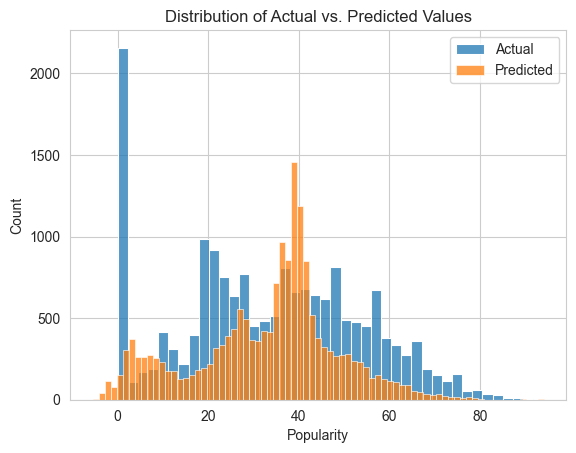

In [253]:
sns.histplot(y_test, label="Actual")
sns.histplot(y_pred_vr, label="Predicted")
plt.xlabel("Popularity")
plt.title("Distribution of Actual vs. Predicted Values")
plt.legend()
plt.show()

In this case, it looks like the distribution follows better the one of the actual values, although it still follows the pattern that linear regression had. It is interesting to note that the peak around 40, as there was in random forest, is much lower.

We proceed with a stacking regressor

### Stacking Regressor

In [22]:
base_models = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(max_depth=15, max_features='auto', min_samples_split=10, n_estimators=100, random_state=42))]

meta_model = LinearRegression()

# Define the stacking regressor
stacking_reg = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stacking regressor on the training data
stacking_reg.fit(X_train_scaled, y_train)

# Predict on the training set
y_pred_tr_st = stacking_reg.predict(X_train_scaled)

# Predict on the test set
y_pred_st = stacking_reg.predict(X_test_scaled)

/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/giuliaghislanzoni/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

In [23]:
print("R2 train: ", r2_score(y_train, y_pred_tr_st))
print("R2 test: ", r2_score(y_test, y_pred_st))

print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_tr_st)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_st, squared=False)))

R2 train:  0.8094491827410535
R2 test:  0.7377135864195399
Training RMSE:  8.983136949628994
Test RMSE:  3.2443702464939883


The stacking regressor model shows a strong performance in predicting the target variable.

It explains approximately 80.9% of the variance in the training data and 73.8% of the variance in the test data. The R2 values suggest that the model performs well in explaining the variance in both sets, although it looks like there is still a bit of overfitting.

However, the test set RMSE of 3.24 is significantly lower than the training set RMSE of 8.98, suggesting that the model can still generalize moderately well and is able to make good predictions on unseen data, and that it is effective in capturing the underlying patterns and relationships in the data.

We now look at the distribution of the actual and predicted values

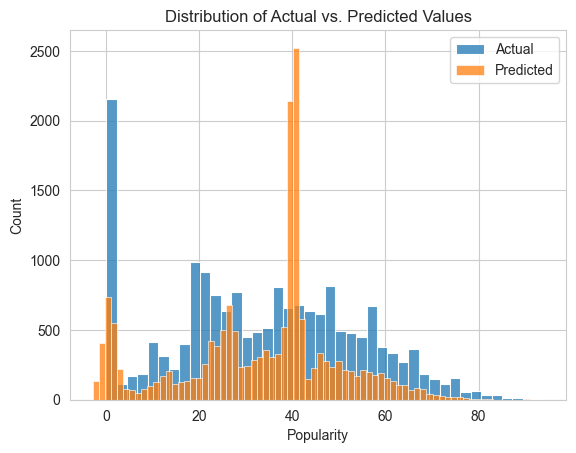

In [258]:
sns.histplot(y_test, label="Actual")
sns.histplot(y_pred_st, label="Predicted")
plt.xlabel("Popularity")
plt.title("Distribution of Actual vs. Predicted Values")
plt.legend()
plt.show()

In this case, the trend that the predicted values follow is the one we had observed in random forest, with a peak around 40. This obviously might have been impacted the performance, as it is clear that many values were incorrectly predicted.

Now, we gather the results of all the models into a single dictionary so that we can create a table to display all the results.

In [26]:
results = {}

results["Linear Regression"] = {
    "R2 train": r2_score(y_train, y_pred_tr_lr),
    "R2 test": r2_score(y_test, y_pred_lr),
    "rMSE train": np.sqrt(metrics.mean_squared_error(y_train, y_pred_tr_lr)),
    "rMSE test": np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr))
}
results["Decision Tree Regr"] = {
    "R2 train": r2_score(y_train, y_pred_tr_dt),
    "R2 test": r2_score(y_test, y_pred_dt),
    "rMSE train": np.sqrt(metrics.mean_squared_error(y_train, y_pred_tr_dt)),
    "rMSE test": np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt))
}
results["Random Forest Regr"] = {
    "R2 train": r2_score(y_train, y_train_pred_rf),
    "R2 test": r2_score(y_test, y_test_pred_rf),
    "rMSE train": np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_rf)),
    "rMSE test": np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_rf))
}
results["Gradient Boosting Regr"] = {
    "R2 train": r2_score(y_train, y_pred_train_gb),
    "R2 test": r2_score(y_test, y_pred_gb),
    "rMSE train": np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_gb)),
    "rMSE texst": np.sqrt(metrics.mean_squared_error(y_test, y_pred_gb))
}
results["Voting Regressor"] = {
    "R2 train": r2_score(y_train, y_pred_tr_vr),
    "R2 test": r2_score(y_test, y_pred_vr),
    "rMSE train": np.sqrt(metrics.mean_squared_error(y_train, y_pred_tr_vr)),
    "rMSE test": np.sqrt(metrics.mean_squared_error(y_test, y_pred_vr))
}
results["Stacking Regressor"] = {
    "R2 train": r2_score(y_train, y_pred_tr_st),
    "R2 test": r2_score(y_test, y_pred_st),
    "rMSE train": np.sqrt(metrics.mean_squared_error(y_train, y_pred_tr_st)),
    "rMSE test": np.sqrt(metrics.mean_squared_error(y_test, y_pred_st))
}


In [27]:
from tabulate import tabulate

# Convert the results dictionary to a list of lists
table_data = []
for model, metrics in results.items():
    row = [model]
    row.extend([f"{value:.2f}" for value in metrics.values()])
    table_data.append(row)

# Define the headers for the table
headers = ["Model", "R2 train", "R2 test", "rMSE train", "rMSE test"]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt="grid"))



+------------------------+------------+-----------+--------------+-------------+
| Model                  |   R2 train |   R2 test |   rMSE train |   rMSE test |
+========================+============+===========+==============+=============+
| Linear Regression      |       0.69 |      0.65 |        11.47 |       12.14 |
+------------------------+------------+-----------+--------------+-------------+
| Decision Tree Regr     |       0.59 |      0.54 |        13.22 |       13.91 |
+------------------------+------------+-----------+--------------+-------------+
| Random Forest Regr     |       0.81 |      0.73 |         8.96 |       10.63 |
+------------------------+------------+-----------+--------------+-------------+
| Gradient Boosting Regr |       0.85 |      0.8  |         8.03 |        9.3  |
+------------------------+------------+-----------+--------------+-------------+
| Voting Regressor       |       0.78 |      0.72 |         9.62 |       10.82 |
+------------------------+--

The voting regressor and the gradient boosting models performed well, in terms of both R2 and RMSE. However, it is important to acknowledge that predicting the popularity of a song with algorithmic models is not always highly accurate, and will possibly never be. Indeed, song popularity is influenced by various factors that are not always measurable, such as cultural trends and individual preferences, but also advertising strategies of the individual artists and their managers, as well as the social and political landscape.